In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy import table, coordinates
from astropy.io import fits

from ekfplot import plot as ek
from ekfparse import query
from ekfphot import image, photometry

In [3]:
from astropy import units as u
from astropy import cosmology
cosmo = cosmology.FlatLambdaCDM(70.,0.3)

In [4]:
cat = table.Table(fits.getdata('../local_data/inputs/Merian_DR1_photoz_EAZY_v3.0_inbandspecz.fits', 1))

# Catalog matching

In [5]:
from astroquery.mast import Catalogs
import progressbar

In [6]:
rsep = 0.2*u.deg
match_sep = 5.*u.arcsec

In [12]:
rerun = True
galex_df = pd.read_csv('./galex_df.csv.scratch', index_col=0)
galex_df['z_spec'] = cat['z_spec']
galex_df['z_source'] = cat['z_source']

In [9]:
mcoords = coordinates.SkyCoord(cat['coord_ra_Merian'], cat['coord_dec_Merian'], unit='deg')
assns = np.zeros(len(mcoords))
group_number = 1
pbar = progressbar.ProgressBar(maxval=len(mcoords))
pbar.start()
anchor_points = []
anchor_names = []
for idx,row in enumerate(mcoords):
    if assns[idx] > 0:
        continue
    relative_positions = row.separation(mcoords) 
    assns[(relative_positions<rsep)&(assns==0)] = group_number
    group_number += 1
    pbar.update(idx)
    anchor_points.append(row)
    anchor_names.append(f'M{cat[idx]["objectId_Merian"]}')

In [11]:
has_run = not galex_df.loc[anchor_names[-1]].isna().all()
print(has_run)

True


In [13]:
#galex_df.to_csv('../local_data/intermediates/galex_df_w_specz.csv')

In [ ]:
if rerun or not has_run:
    pbar = progressbar.ProgressBar(maxval=len(anchor_points))
    pbar.start()
    
    columns = 'fuv_mag fuv_magerr nuv_mag nuv_magerr fuv_flux fuv_fluxerr nuv_flux nuv_fluxerr e_bv ra dec fuv_artifact nuv_artifact IAUName'.split()
    if rerun:
        galex_df = pd.DataFrame(index=[f'M{x}' for x in cat['objectId_Merian']], columns=columns)
    for group_index in range(1, len(anchor_points)+1):
        name = anchor_names[group_index-1]
        if not galex_df.loc[name].isna().all():
            pbar.update(group_index)
            continue
        row = anchor_points[group_index-1]    
        catalog_data = Catalogs.query_region(row, radius=rsep, catalog='Galex').to_pandas()
        ccoords = coordinates.SkyCoord(catalog_data['ra'], catalog_data['dec'], unit='deg')
        if len(ccoords)==0:
            continue
        match_index, d2d,_=mcoords[assns==group_index].match_to_catalog_sky(ccoords)
        is_match = d2d < match_sep
        matches = [f'M{x}' for x in cat[assns==group_index][is_match]['objectId_Merian']]
        galex_df.loc[matches] = catalog_data.reindex(match_index[is_match])[columns].values
        pbar.update(group_index)
    
        if group_index % 10 == 0:
            galex_df.to_csv('./galex_df.csv.scratch')
    
    galex_df.to_csv('./galex_df.csv.scratch')
else:
    print('using scratch')

In [24]:
nuv_flux = 3631.*10.**(galex_df['nuv_mag'].values.astype(float)/-2.5)
fuv_flux = 3631.*10.**(galex_df['nuv_mag'].values.astype(float)/-2.5)

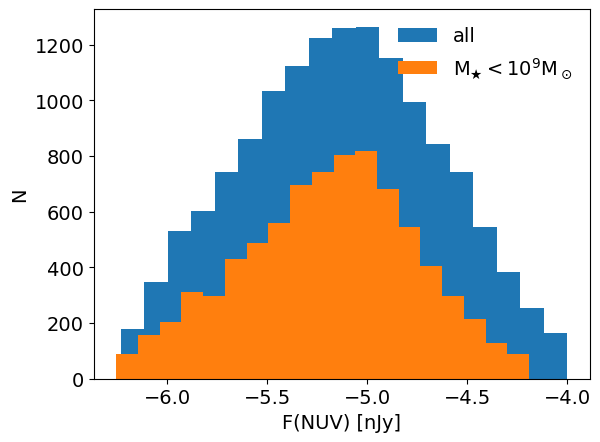

In [25]:
ek.hist(np.log10(nuv_flux), label='all')
ek.hist(np.log10(nuv_flux)[cat['logmass_gaap']<9.], label=r'$\rm M_\bigstar<10^9 M_\odot$')
plt.xlabel(r'F(NUV) [nJy]')
plt.ylabel('N')
plt.legend(frameon=False)

In [27]:
plt.scatter(
    cat['logmass_gaap'],
    fuv_flux/

(17975,)

In [ ]:
cat

# Galex pixels

In [49]:
matches = query.identify_galexcoadds(row['coord_ra_Merian'], row['coord_dec_Merian'])

Queried GALEX observations in 1.25 seconds.


In [ ]:
catalog_data = Catalogs.query_object_async

In [50]:
gsavedir = '/Users/kadofong/work/surveys/merian/agrias/local_data/cutouts/galex'
mid = f'M{row["objectId_Merian"]}'
cra,cdec = row['coord_ra_Merian'], row['coord_dec_Merian']
query.download_galeximages(cra, cdec, mid, savedir=gsavedir)

Queried GALEX observations in 0.12 seconds.
Identified GALEX observations in 0.65 seconds.


/Users/kadofong/work/ekfutils/ekfparse/ekfparse/query.py:244: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/kadofong/work/surveys/merian/agrias/local_data/cutouts/galex/M2950284366439293259//keys.txt' mode='w' encoding='UTF-8'>
  open(f'{target}/keys.txt','w').write(f'''FUV,{names[0]}


Downloaded GALEX observations in 7.50 seconds.
Saved to: /Users/kadofong/work/surveys/merian/agrias/local_data/cutouts/galex/M2950284366439293259/mastDownload/GALEX/6380380452510760960


(0,
 <Table length=15>
                                                                                 Local Path                                                                                ...
                                                                                   str169                                                                                  ...
 ------------------------------------------------------------------------------------------------------------------------------------------------------------------------- ...
 /Users/kadofong/work/surveys/merian/agrias/local_data/cutouts/galex/M2950284366439293259/mastDownload/GALEX/3209380021181349888/GI5_028080_W1_18028_0270-nd-flags.fits.gz ...
  /Users/kadofong/work/surveys/merian/agrias/local_data/cutouts/galex/M2950284366439293259/mastDownload/GALEX/3209380021181349888/GI5_028080_W1_18028_0270-nd-rrhr.fits.gz ...
 /Users/kadofong/work/surveys/merian/agrias/local_data/cutouts/galex/M2950284366439293259/mastDownload

In [51]:
gpackage = query.load_galexcutouts(mid, gsavedir, (cra,cdec), 100,100)

M2950284366439293259 maps to GI5_028080_W1_18028_0270


/Users/kadofong/work/ekfutils/ekfparse/ekfparse/query.py:295: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/kadofong/work/surveys/merian/agrias/local_data/cutouts/galex/M2950284366439293259/keys.txt' mode='r' encoding='UTF-8'>
  keyinfo = open(keypath,'r').read().splitlines()
/Users/kadofong/work/ekfutils/ekfparse/ekfparse/query.py:374: RuntimeWarning: overflow encountered in square
  variance = fits.ImageHDU ( cts / rrhr[0].data**2, header=intmap[0].header, name='VARIANCE' )
/Users/kadofong/work/ekfutils/ekfparse/ekfparse/query.py:374: RuntimeWarning: invalid value encountered in divide
  variance = fits.ImageHDU ( cts / rrhr[0].data**2, header=intmap[0].header, name='VARIANCE' )


M2950284366439293259 maps to AIS_269_sg94


/Users/kadofong/work/ekfutils/ekfparse/ekfparse/query.py:374: RuntimeWarning: overflow encountered in square
  variance = fits.ImageHDU ( cts / rrhr[0].data**2, header=intmap[0].header, name='VARIANCE' )
/Users/kadofong/work/ekfutils/ekfparse/ekfparse/query.py:374: RuntimeWarning: invalid value encountered in divide
  variance = fits.ImageHDU ( cts / rrhr[0].data**2, header=intmap[0].header, name='VARIANCE' )


(<matplotlib.image.AxesImage at 0x16cefa950>, <Axes: >)

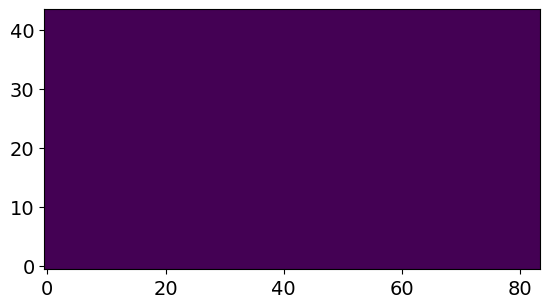

In [54]:
ek.imshow(gpackage['nd'][0].data)